# Heirarchical Loss Function
> Creating a heirarchical loss function to improve classification accuracy

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

For this post, I am going to make a modification to the loss function.  The goal will be to weight losses differently.  Why should we treat all classes the same in our loss function if they aren't?

In this blog we are going to do an image classification to take pet pictures and predict the breed.  Normally, each class is treated the same when calculating the loss function.  In this post I will explore a change to take into account weighting classes differently. For example, If a picture is a maincoon, predicting a sphynx (wrong type of cat) is less egregious of an error than predicting pitbull.  I want my loss function to reflect this.

If you think about it intuitively when we teach children - if we show a child an apple and the chile thinks it's a peach - We probably wouldn't just tell the child he is wrong.  We would probably tell him he is close, but that it's a different fruit and really it's an apple.  Neural networks benefit from having this extra piece of information which is what this post will look to do in a loss function.

I am going to skim over loading the data and training the model, feel free to see my Fine Grain Image Classifier post from Jun-27-2020 if you want more detail on those aspect.

# Setup

### Library Import and Dataset Download

In [1]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
from pylab import rcParams
from torch.nn.functional import nll_loss,log_softmax

seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
img = (path/'images').ls()[0]

### Data Prep

Load the Data in a data block, take a look at the classes and scale the images down a bit so the problem isn't too easy.

In [3]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=56)
)

/Users/isaac.flath/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


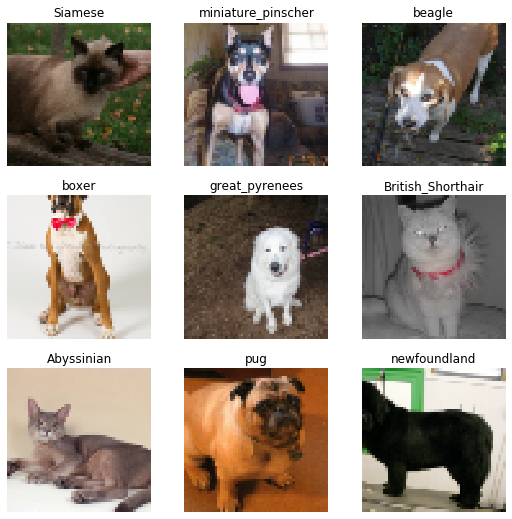

In [4]:
dls = pets.dataloaders(path/"images",bs=64)
dls.show_batch()

### Classes

We can see in our dls object the class names in the order our predictions and labels will be in. I went through and found that the first 12 classes are all cats, and the last 25 classes are all dogs.  This will be important as we are creating the heirarchy at that level.

In [9]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [4]:
# first 12 classes are casts, next 25 are dogs.
pet_type = ['cat']*12+['dog']*25

# Custom Stuff

### Metrics

I need to measure the accuracy at the 2 levels in the heirarchy (breed and species levels).  The goal is that I can impact them differently by modifying the weights in my loss function.  Ultimately what I care about is the accuracy not whatever the loss function says, so I need to define the metrics for each level.  These will be the metrics to determine is this approach is working or not.

In [10]:
def accuracy_breed(inp, targ, axis=-1):
    # Compute Accuracy as normal - function straight from fastai library
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()


def accuracy_species(inp, targ, axis=-1):
    
    #convert input (35 classes of breeds) into new_input (cat or dog)
    temp = [torch.argmax(x) for x in inp]
    new_inp = tensor([(x > 11).int() for x in temp])    
    
    # conver target (35 classes of breeds) into new_target (cat or dog)
    new_targ = tensor([(x > 11).int() for x in targ])

    return (new_inp == new_targ).float().mean()

### Loss Function

The loss functions are what will actually be optimized.  The loss function is what the model will calculate the gradients off of to update our weights.  I am doing a linear combination of cross entropy loss at the 2 levels of the heirarchy.  I have a weight $w$ which I can change to change the proportion of these. use a weight to change the proportion of which level I use.

In [6]:
def cross_entropy_species(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    # softmax to convert scores to probabilities
    input_p = torch.softmax(input,dim=-1)
    return nll_loss(torch.log(input_p), target, None, None, ignore_index, None, reduction)

def cross_entropy_breed(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    
    # softmax to convert scores to probabilities
    input_p = torch.softmax(input,dim=1)
    
    # changes from many classes down to 2 classes for both input and target
    # Sum the probabilities for all the cat breeds to get probability it's a cat.  Same for dog
    cats = torch.sum(input_p[:,0:12],dim=1).view(input_p.shape[0],1)
    dogs = torch.sum(input_p[:,12:37],dim=1).view(input_p.shape[0],1)  
    
    # format new inputs and new targets for 2 classes
    new_input = torch.cat([cats,dogs],-1)
    new_target = TensorCategory((target > 11).long(),device='cuda:0')

    # Finish calculation for cross-entropy using new inputs and targets
    return nll_loss(torch.log(new_input), new_target, None, None, ignore_index, None, reduction)

def final_loss(input, target, w=1, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    ce_species = cross_entropy_species(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    ce_breed = cross_entropy_breed(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    # Linear combination of the cross-entropy scores at the 2 levels in heirarchy.
    return w*ce_species+(1-w)*ce_breed
    

# Experiments

Here I wanted to run tests at different weights to see how they performed.  I ran one with 3 epochs and one with 10 epochs.  I did multiple runs at the same weights so I could see if I was getting stuck in different local minimums due to the change.  

I found that in general, this can help some.  Using a slight amount of weight toward the species helps the neural network optimize better.  This makes sense as we are giving it some more information.  We are telling the neural network more than right class vs wrong class.  We are now giving it a third option (right class vs wrong class but close vs totally wrong class).  Having this extra piece of information is helpful for training your model and is what we are building into the loss function below.

In [ ]:
from functools import partial
results = pd.DataFrame()
id_num = 1

# weights between 0 and 1, incrementing by 0.05
weights = np.array(range(0,21))/20

for w in weights:
    for i in range(0,5):
        print(w)
        
        # Take my loss function and sets the default weight to my new weight
        tmp_loss = partial(final_loss,w=w)
        
        #Create basic CNN with smart defaults
        learn = cnn_learner(dls, resnet18, metrics=[accuracy_breed,accuracy_species], pretrained=True, loss_func = tmp_loss)
        
        # Fine tune take pretrained model, trains the final layers, unfreezes, then trains the full model
        learn.fine_tune(3)

        # Store the results
        df = pd.DataFrame(learn.recorder.values)
        df.columns = learn.recorder.metric_names[1:-1]
        df['w'] = w
        df['id'] = id_num
        results = results.append(df)
        
        id_num = id_num + 1
        
        learn = None
        torch.cuda.empty_cache()

In [8]:
# Save results for analysis later
results.to_csv('results.csv')

In [ ]:
# same as above, slightly different configurtion
from functools import partial
weights = np.array(range(0,11))/10
results = pd.DataFrame()
id_num = 1
for w in weights:
    for i in range(0,5):
        print(w)
        tmp_loss = partial(final_loss,w=w)
        learn = cnn_learner(dls, resnet18, metrics=[accuracy_breed,accuracy_species], pretrained=True, loss_func = tmp_loss)
        learn.fine_tune(10)

        df = pd.DataFrame(learn.recorder.values)
        df.columns = learn.recorder.metric_names[1:-1]
        df['w'] = w
        df['id'] = id_num
        
        results = results.append(df)
        
        id_num = id_num + 1
        
        learn = None
        torch.cuda.empty_cache()

In [10]:
# Save results for analysis later
results.to_csv('results2.csv')

# Results

Overall both over 3 and 10 epochs showed the same thing, which is weighting the Breed level (higher level then our task) between 20% and 40% seems to improve performance for both breed as well as species.  I suspect that this should be treated as another thing to tune and not something you can arbitrarily set for all datasets.

This seems to indicate that when you have an obvious heirarchy in your data, using this methodology (and possibly extending it for multi-level heirarchies) can help overall performance of the model.  Graphs of results below

In [ ]:
#collapse-hide
def graph_results(df):
    rcParams['figure.figsize'] = 20, 10

    graph1 = df[['accuracy_breed','accuracy_species','w']].groupby('w').max().reset_index()
    graph2 = df[df.epochs == max(df.epochs)][['accuracy_breed','accuracy_species','w']].groupby('w').mean().reset_index()

    plt.suptitle("Weight * BreedLoss + (1 - Wieght) * SpeciesLoss", fontsize=14)
    plt.subplot(2, 2, 1)
    plt.plot('w', 'accuracy_breed', data=graph1, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.title('Max Accuracy (Breed)')
    plt.xlabel('Weight')
    plt.ylabel('Accuracy')
    plt.subplot(2, 2, 2)
    plt.plot('w', 'accuracy_species', data=graph1, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.title('Max Accuracy (Species)')
    plt.xlabel('Weight')
    plt.ylabel('Accuracy')
    plt.subplot(2, 2, 3)
    plt.plot('w', 'accuracy_breed', data=graph2, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.title('Avg Final Epoch Accuracy (Breed)')
    plt.xlabel('Weight')
    plt.ylabel('Accuracy')
    plt.subplot(2, 2, 4)
    plt.plot('w', 'accuracy_species', data=graph2, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.title('Avg Final Epoch Accuracy (Species)')
    plt.xlabel('Weight')
    plt.ylabel('Accuracy')

# 3 epochs

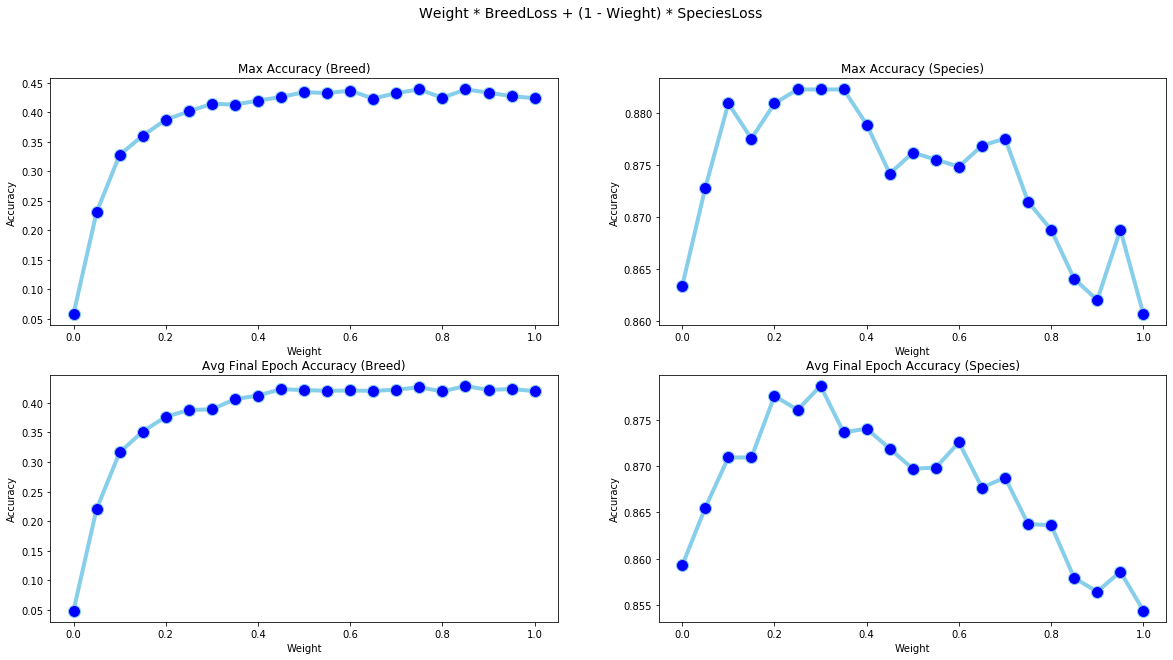

In [5]:
df = pd.read_csv("results.csv", skiprows=1, names = ['epochs', 'train_loss', 'valid_loss', 'accuracy_breed','accuracy_species', 'w', 'id'])
graph_results(df)

# 10 epochs

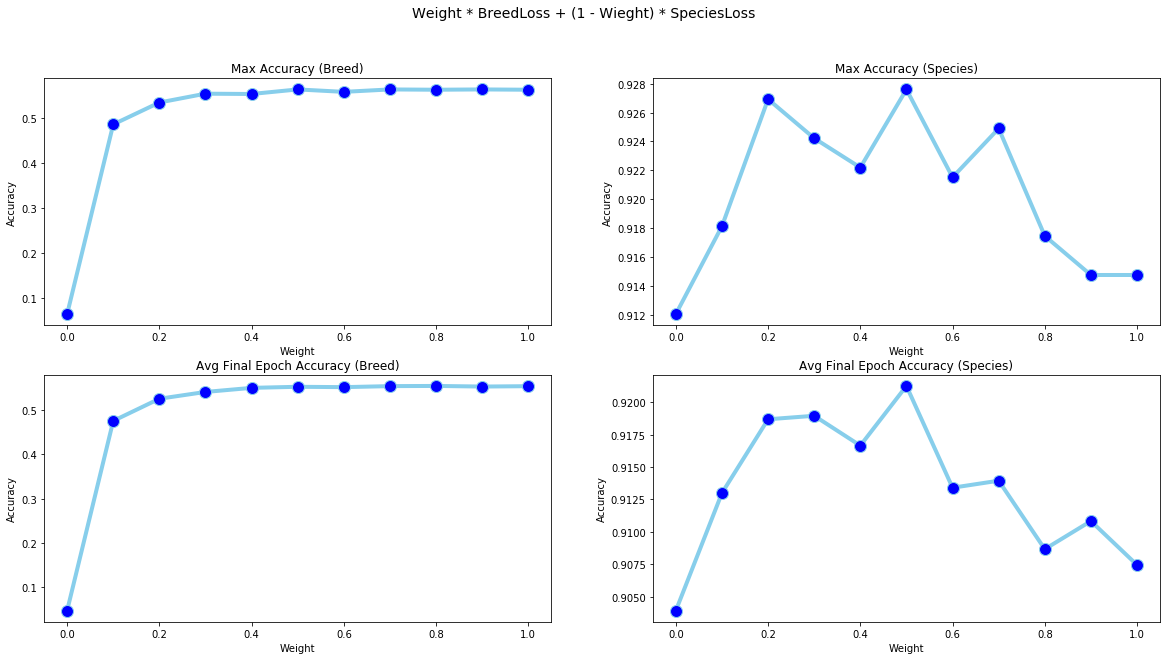

In [6]:
df = pd.read_csv("results2.csv", skiprows=1, names = ['epochs', 'train_loss', 'valid_loss', 'accuracy_breed','accuracy_species', 'w', 'id'])
graph_results(df)